# PS2
### Fiona Fan


In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
import pandas as pd
import statsmodels.api as sm


C:\Users\jfan3\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## (a)

In [4]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')
# prcntl = [0.25,0.25,0.2,0.1,0.1,0.09,0.01]
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
ages=np.linspace(18,95,78)
bq_data.shape
ages.shape

(78,)

(78, 7) (78, 7) (78, 7)


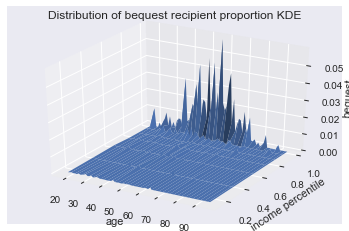

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y_mat, x_mat=np.meshgrid(lambdas_mdpts,ages)
print(x_mat.shape,y_mat.shape,bq_data.shape)
ax.set_xlabel('age')
ax.set_ylabel('income percentile')
ax.set_zlabel('bequest')
ax.set_title('Distribution of bequest recipient proportion KDE')
ax.plot_surface(x_mat,y_mat , bq_data)


## (b)


In [6]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data);

C:\Users\jfan3\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\jfan3\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
grid.best_params_

{'bandwidth': 0.1}

The best bandwidth is 0.1.

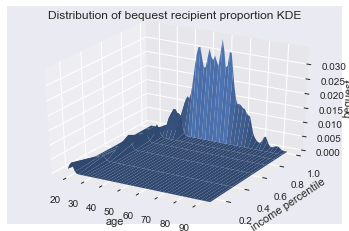

In [8]:
bandwidth=0.1
abils_midpt = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(ages, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(lambdas_mdpts, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)

ages_mat, abils_mat=np.meshgrid(ages,lambdas_mdpts)

coords = np.vstack([item.ravel() for item in [ages_mat, abils_mat]])
BQkde = density(coords).reshape(ages_mat.shape)
BQkde_scaled = BQkde / BQkde.sum()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('age')
ax.set_ylabel('income percentile')
ax.set_zlabel('bequest')
ax.set_title('Distribution of bequest recipient proportion KDE')
ax.plot_surface(ages_mat,abils_mat , BQkde_scaled)

In [9]:
BQkde_scaled[5,61-18+1]

5.208058001672237e-07

In [18]:
bd=pd.read_csv("biden.csv")
bd.head()

,biden,female,age,educ,dem,rep
0,90.0,0,19.0,12.0,1.0,0.0
1,70.0,1,51.0,14.0,1.0,0.0
2,60.0,0,27.0,14.0,0.0,0.0
3,50.0,1,43.0,14.0,1.0,0.0
4,60.0,1,38.0,14.0,0.0,1.0


In [19]:
bd['ageXeduc']=bd.age*bd.educ
# bd.dropna(inplace=True)
bd['const']=1
X=bd[['age','educ','ageXeduc','const']]
y=bd.biden
model = sm.OLS(y, X, missing='drop').fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Sun, 29 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        20:42:55   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.6674      0.169      3.950      0.000       0.336       0.999
educ           1.7123      0.709      2.414      0.016       0.321       3.103
ageXeduc      -0.0477      0.013     -3.728      0.000      -0.073      -0.023
const         37.5491      9.491      3.956      0.000      18.935      56.163
==============================================================================
Omnibus:                       64.792   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.979
Skew:                          -0.480   Prob(JB):                     3.86e-16
Kurtosis:                       3.105   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## a).

The marginal effect of age is $\beta_1+\beta_3 X_2$, and the estimated effect is $0.67-0.048 educ$, with all coefficients significant at $p< 0.001$. Therefore, the effect of age on biden feelings decreases with more education. 

## b).

The marginal effect of education is $\beta_2+\beta_3 X_1$, and the estimated effect is $1.71-0.048 age$, with all coefficients significant at $p< 0.001$. Therefore, the effect of education on biden feelings also decreases with older age.
